# Bitcoin Time Series Forecasting

+ This shows how volatile this asset is, which makes it one of the more interesting time series to explore, as opposed to standard stocks
+ It's quite interesting to see how this digital asset has resurged in value after a recent dip, especially in the current financial climate
+ There are quite a number of factors that can affect the asset, and we'll only be looking at traditional stock based factors

## STOCK PRICE INFLUENCES
#### CORRELATED ASSETS
An organization depends on and interacts with many external factors, including its competitors, clients, the global economy, the geopolitical situation, fiscal and monetary policies, access to capital, and so on. Hence, its stock price may be correlated not only with the stock price of other companies but also with other assets such as commodities, FX, broad-based indices, or even fixed income securities.
#### TECHNICAL INDICATORS
A lot of investors follow technical indicators. Moving average, exponential moving average, and momentum are the most popular indicators.

## PROBLEM DEFINITION
+ A major drawback of crypocurrency trading is the **volatility** of the market.
+ The currency trades can occur 24/7 & tracking crypto position can be an impossible task to manage without automation.
+ Automated Machine Learning trading algorithms can assist in managing this task, in order to predict the market's movement.
+ We can use models to classify future movements into three categries:
    + 1) The market will rise (take long position),
    + 2) The market will fall (take short position) 
    + 3) The market will move sideways (take no position).

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from plotly import tools
from chart_studio import plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go


import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (13, 8)

from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

import warnings
# switch off the warnings
warnings.filterwarnings("ignore")

# Data Exploration
### READING DATASET - 
+ Current dataset : CSV file for select bitcoin exchanges for the time period of Jan 2012 to March 2021, 1-min interval data (dataset)
+ The feature timestamp can be parsed into a more conventional time index using the pytz library.
+ The Baseline Features include: the asset's minute's open,high,low,close,Volume_(BTC),Volume_(Currency) & Weighted_Price

In [2]:
import datetime, pytz
#define a conversion function for the native timestamps in the csv file, which convert to readable timestamp
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))


df = pd.read_csv('/Users/DylanC/Desktop/Kaggle/Bitcoin Time Series Forecasting/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv', parse_dates=[0], date_parser=dateparse)

In [3]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 15:52:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 15:53:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 15:54:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 15:55:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 15:56:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cleaning Data
Little preprocessing required, replacing the NaN values with zeroes and previous data.

In [4]:
# First thing is to fix the data for bars/candles where there are no trades occuring. 
# 交易量Volume/trades are a single event, so fill NA's with zeroes for relevant fields...

df['Volume_(BTC)'].fillna(value=0, inplace=True)
df['Volume_(Currency)'].fillna(value=0, inplace=True)
df['Weighted_Price'].fillna(value=0, inplace=True)

# Next we need to fix the OHLC data which is a 'continuous' timeseries. So lets fill forwards or interpolate() those values...
# .interpolate()
df['Open'] = df['Open'].interpolate()
df['High'] = df['High'].interpolate()
df['Low'] = df['Low'].interpolate()
df['Close'] = df['Close'].interpolate()

df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 15:52:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 15:53:00+00:00,4.39,4.39,4.39,4.39,0.000000,0.0,0.00
2,2011-12-31 15:54:00+00:00,4.39,4.39,4.39,4.39,0.000000,0.0,0.00
3,2011-12-31 15:55:00+00:00,4.39,4.39,4.39,4.39,0.000000,0.0,0.00
4,2011-12-31 15:56:00+00:00,4.39,4.39,4.39,4.39,0.000000,0.0,0.00


In [5]:
# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

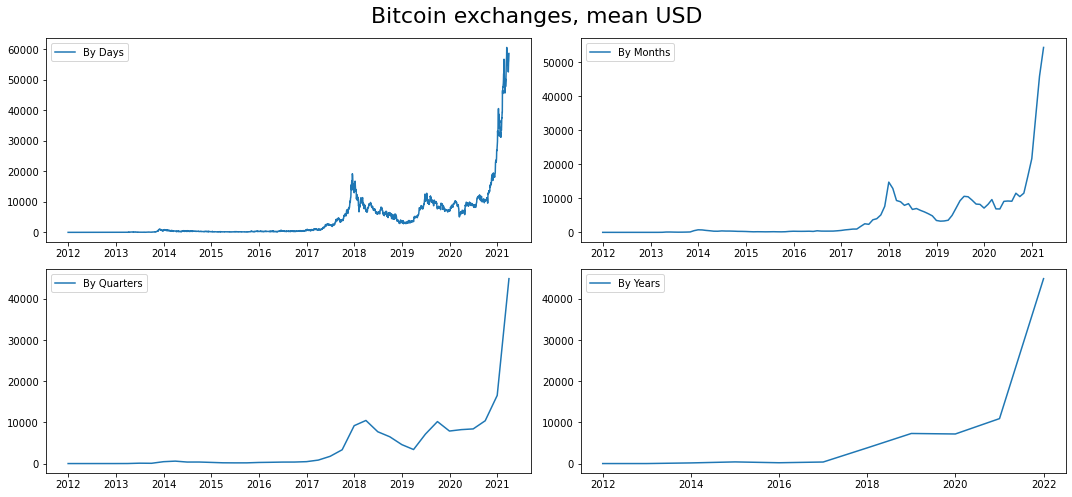

In [6]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

plt.tight_layout()
plt.show()

### Creating Weekly Rows for the Data Visualization

In [7]:
# Since the first couple years of bitcoin don't properly represent the movement and volatility of the price -
# I decide to simply focus on the previous 4 years of data from March 31st, 2021.
df.reset_index(inplace=True)

# create valid date range
start = datetime.datetime(2017, 1, 1, 0, 0, 0, 0, pytz.UTC)
end = datetime.datetime(2021, 3, 31, 0, 0, 0, 0, pytz.UTC)

# find rows between start and end time, and find the first row (00:00 monday morning)
# W-MON, W-TUE...从指定的星期几（MON、TUE、WED、THU、FRI、SAT、SUN）开始算起，每周几
weekly_rows = df[(df['Timestamp'] >= start) & (df['Timestamp'] <= end)].groupby([pd.Grouper(key='Timestamp', freq='W-MON')]).first().reset_index()

weekly_rows.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2015-01-05 00:00:00+00:00,316.879420,316.970753,316.789663,316.877590,4.168197,1321.823071,169.732394
1,2015-01-12 00:00:00+00:00,285.001198,285.226626,284.787057,284.994229,31.239841,8973.557448,257.884400
2,2015-01-19 00:00:00+00:00,252.142240,252.412382,251.796875,252.138545,30.682418,7440.429320,241.138965
3,2015-01-26 00:00:00+00:00,211.776455,211.956444,211.595056,211.785285,9.845411,2079.193266,189.353069
4,2015-02-02 00:00:00+00:00,262.957858,263.301628,262.506559,262.914010,20.012446,5240.323497,235.627554


### Lets visualize Historical Bitcoin Prices (2017-2021)

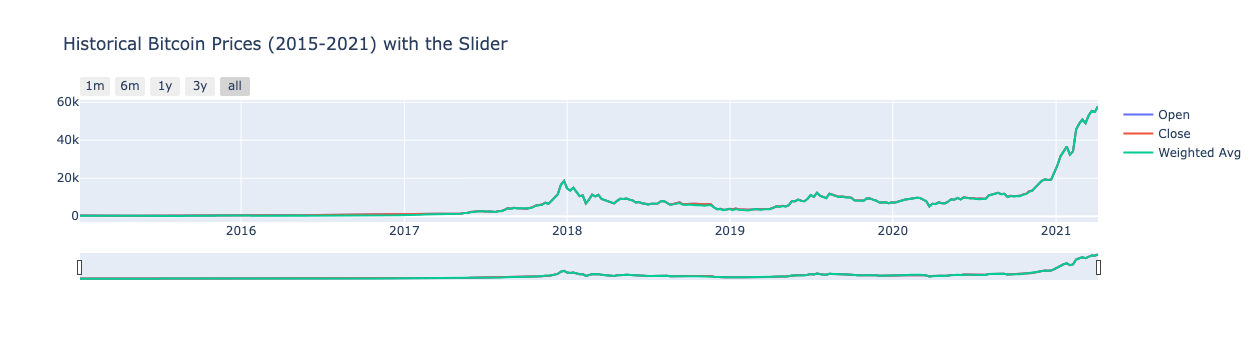

In [8]:
# We use Plotly to create the plots https://plot.ly/python/
trace1 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)

trace3 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Weighted_Price'].astype(float),
    mode = 'lines',
    name = 'Weighted Avg'
)

layout = dict(
    title='Historical Bitcoin Prices (2017-2021) with the Slider ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1, trace2, trace3]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

### Lets visualize Historical Bitcoin Market Volume (2017-2021)

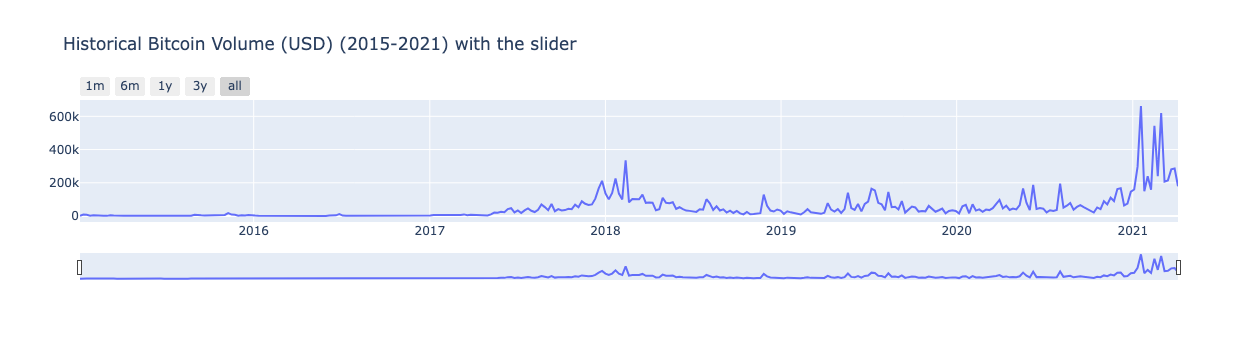

In [9]:
trace1 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Volume_(Currency)'].astype(float),
    mode = 'lines',
    name = 'Bitcoin Price (Open)'
)

layout = dict(
    title='Historical Bitcoin Volume (USD) (2017-2021) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

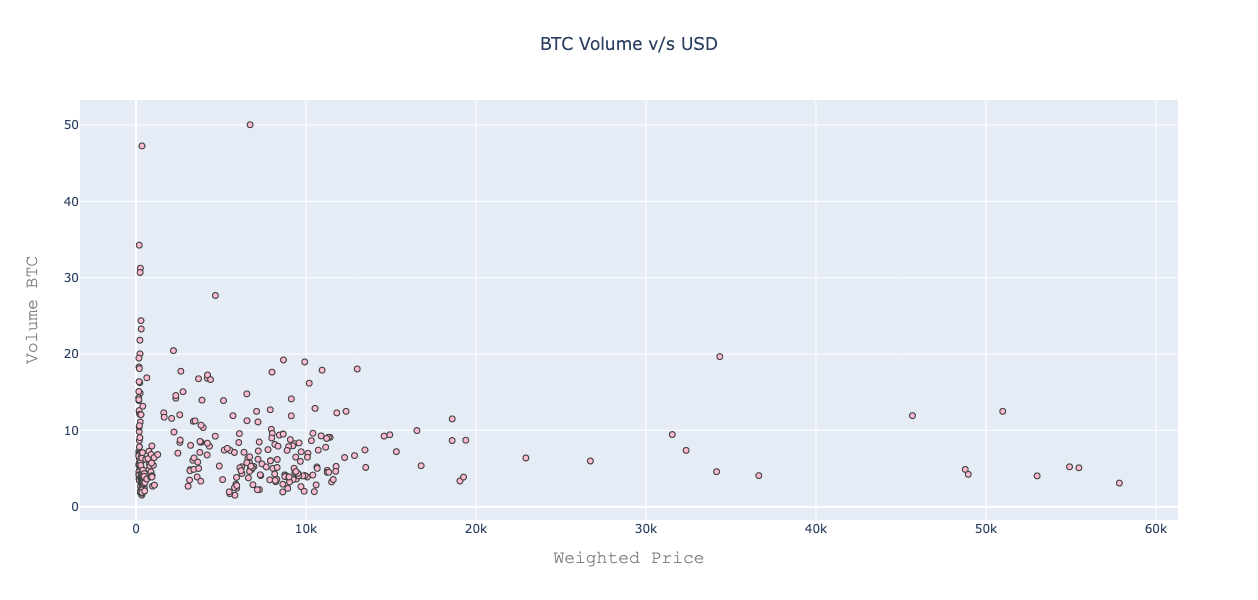

In [10]:
trace = go.Scattergl(
    y = weekly_rows['Volume_(BTC)'].astype(float),
    x = weekly_rows['Weighted_Price'].astype(float),
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    )
)

layout = go.Layout(
    title='BTC Volume v/s USD',
    xaxis=dict(
        title='Weighted Price',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Volume BTC',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )))


data = [trace]
fig = go.Figure(data=data, layout=layout)
fig.update_layout(autosize=False, height=600, width=1200, title_x=0.5)
iplot(fig, filename='compare_webgl')

***

# Time Series Forecasting
Time Series have several key features such as trend, seasonality, and noise.Forecasting is the process of making predictions of the future, based on past and present data.  
Here in this kernel, we attempt to perform Time Series Analysis on the Historic Bitcoin Price data. We can easily see from the <u>**Data Exploration section**</u>, that the Bitcoin prices were quite <u>**volatile and inconsistent**</u> over the years. Its very hard to perform Time series analysis on such volatile data. But here we try to explore the different Time series forecasting models. All the models used in this Kernel are very basic, there is scope of more complex and better performing models.

+ Time Series forecasting with ARIMA
+ Time Series forecasting with XGBoost
+ Time Series forecasting with LSTM

## Predicting using ARIMA
ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

+ AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
+ I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
+ MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

## Stationarity check and STL-decomposition of the series  
https://vocus.cc/article/620f901cfd897800015e49be

### Here we will use the Monthly data (for Seasonality).

In [11]:
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

Dickey–Fuller test: p=0.998858


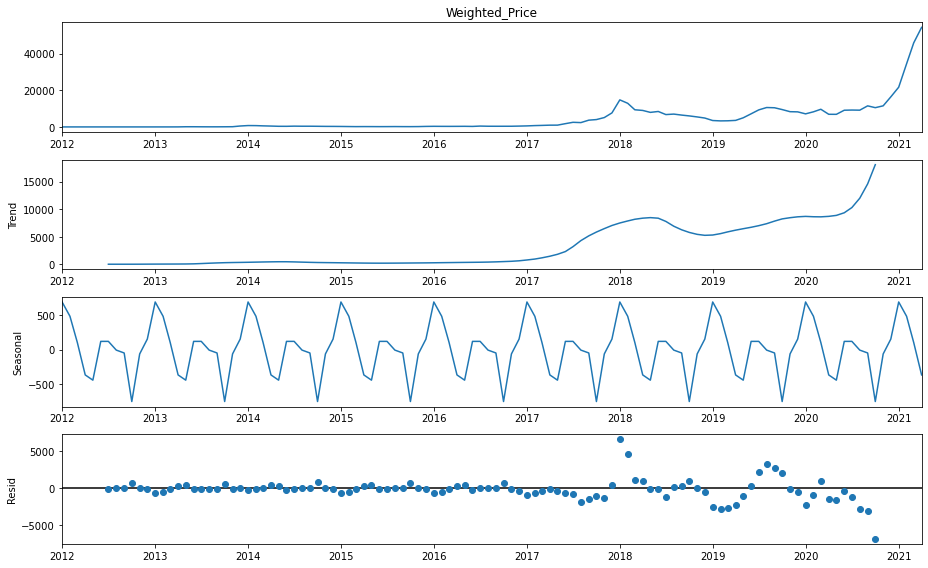

In [12]:
# Decomposition of trend, seasonality, and residual by using  built-in function 'seasonal_decompose'
#plt.figure(figsize=(12,5))
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

plt.show()

In [13]:
df = pd.read_csv('/Users/DylanC/Desktop/Kaggle/Bitcoin Time Series Forecasting/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [14]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# # Here I start cleaning the data. Firstly, converting Timestamp to datetime64 
#去除掉timestamp後綴
#df['Timestamp'] = df['Timestamp'].dt.tz_localize(None) #去除掉timestamp後綴 -> using datetime.datetime() in Prediction section below
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s') 

df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

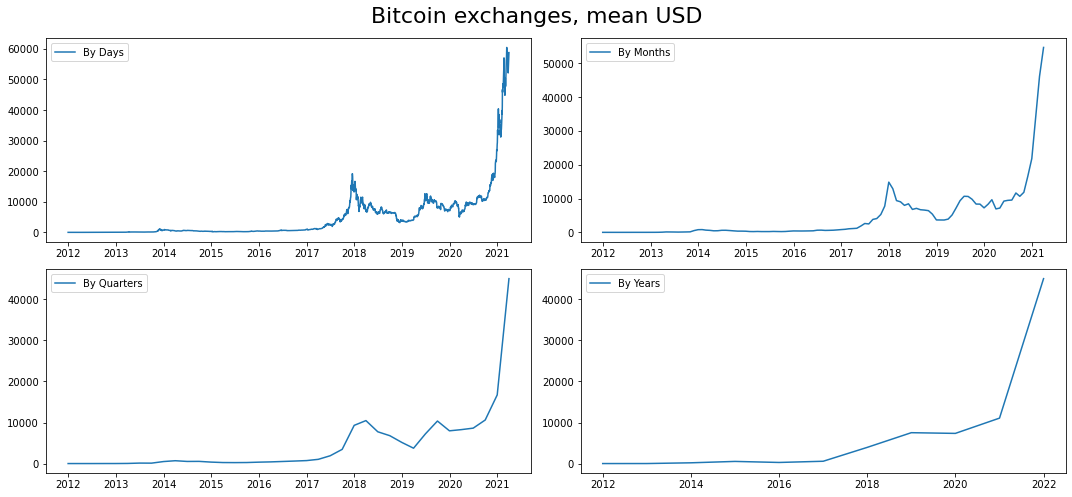

In [17]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

plt.tight_layout()
plt.show()

### use df_month for prediction below

Dickey–Fuller test: p=0.998863


<Figure size 1080x504 with 0 Axes>

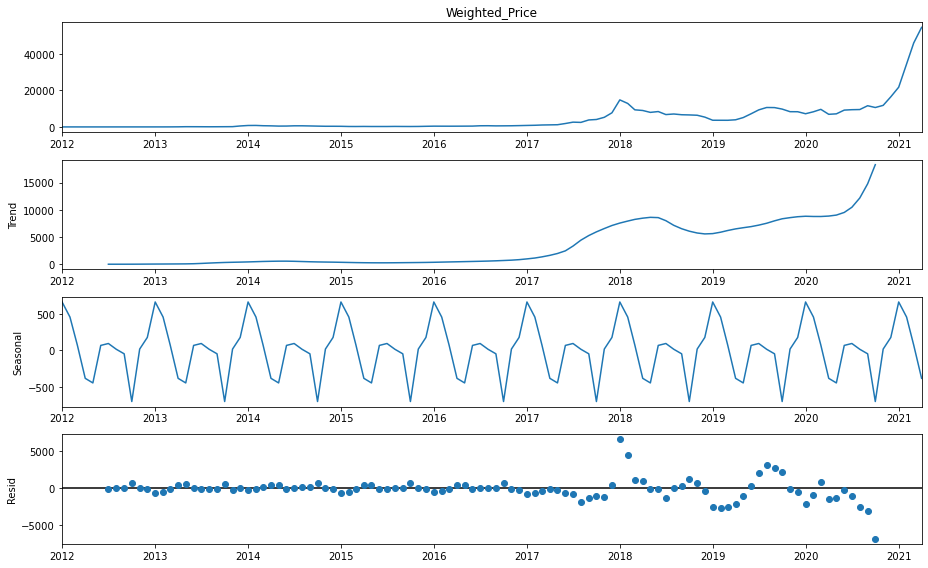

In [18]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

> The series are not stationary.

### ADF檢驗：檢驗data是否為stationary定態資料
#### 一般來說，如果計算出來的p值小於0.05就是定態資料，如果大於0.05就是非定態資料。否則去做差分，直到ADF檢定p值<0.05
+ 1) Seasonal differentiation 首先進行季節性差分
+ 2) Regular differentiation 普通差分，近一步降低p值  
完成以上兩步，來滿足stationary

#### Box-Cox Transformations

In [19]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.998863


> The series are not stationary.

#### Seasonal differentiation

In [20]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.444282


> The series are not stationary.

#### Regular differentiation

Dickey–Fuller test: p=0.000024


<Figure size 1080x504 with 0 Axes>

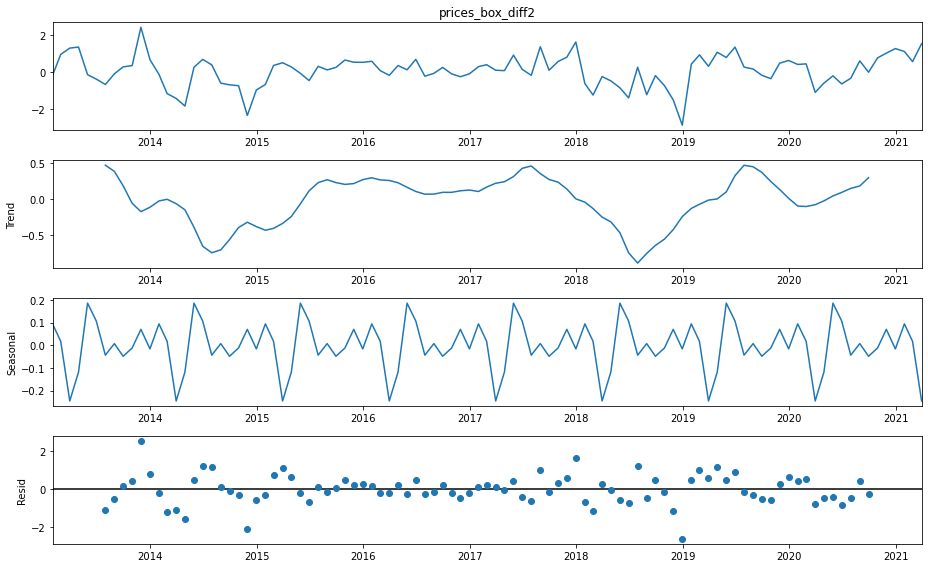

In [21]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

> The series are Stationary.

## Model Selection

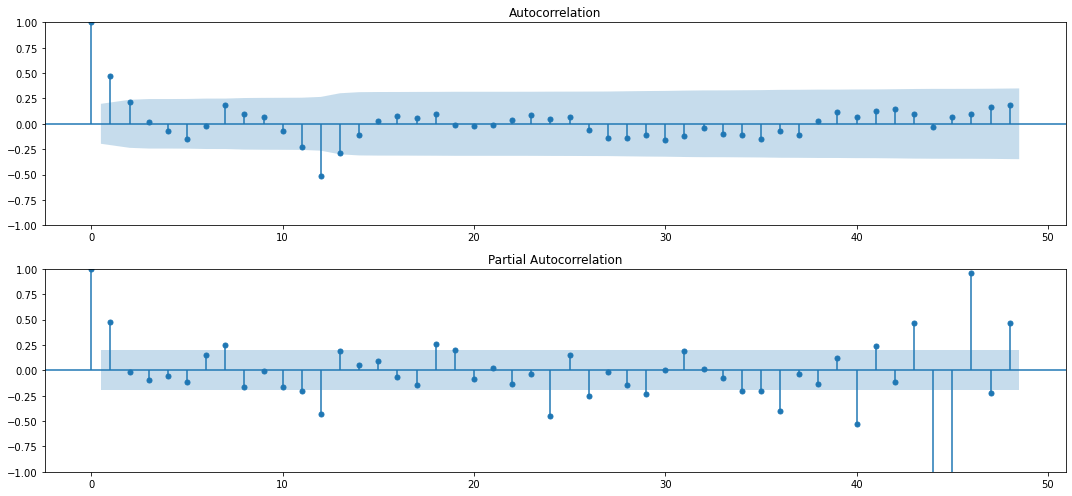

In [22]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

### Grid Serach to find best hyper-parameter p,d,q,P,D,Q

In [23]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [24]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  173.616332
21  (1, 0, 1, 1)  174.766384
25  (1, 1, 0, 1)  175.547174
37  (2, 0, 0, 1)  175.555060
7   (0, 1, 0, 1)  175.589121
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -83.808
Date:                              Sun, 06 Aug 2023   AIC                            173.616
Time:                                      17:56:51   BIC                            181.402
Sample:                                  12-31-2011   HQIC                           176.766
                                       - 03-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

### Analysis of residues

Dickey–Fuller test:: p=0.000000


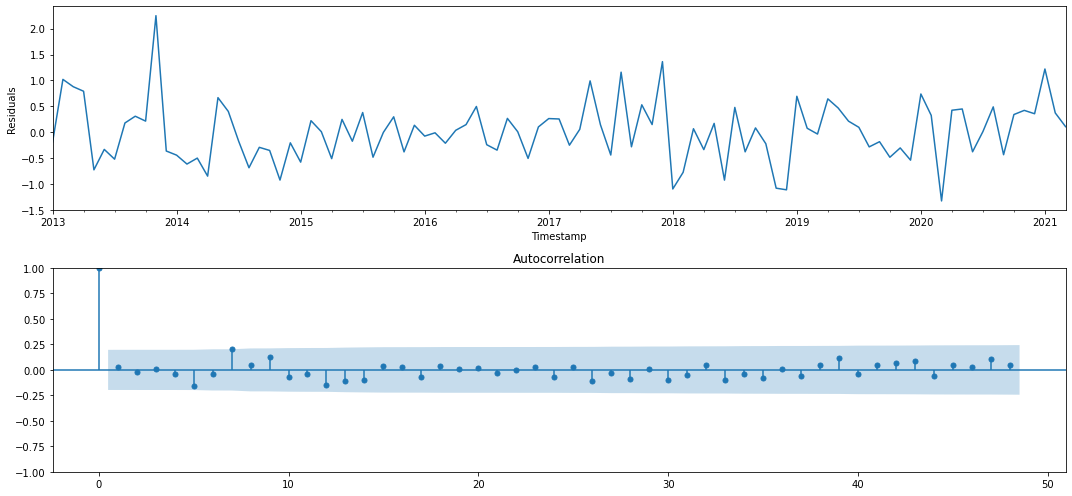

In [25]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

It's OK.

### Prediction

In [26]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

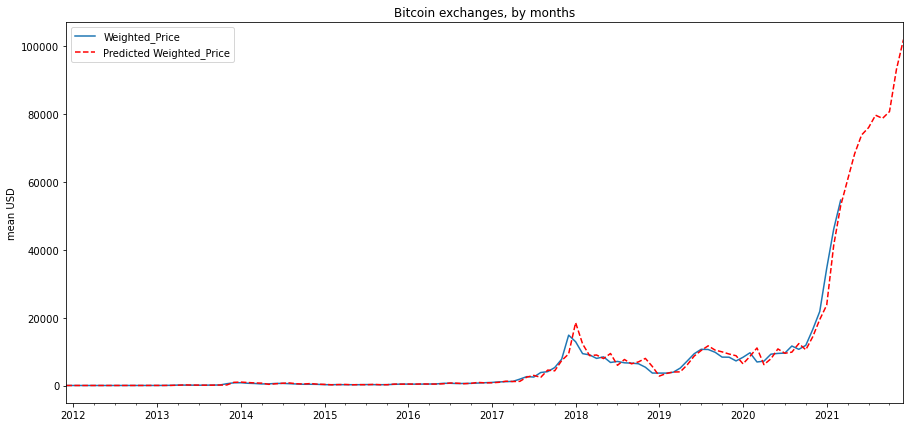

In [27]:
# Prediction
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime.datetime(2021, 4, 30), datetime.datetime(2021, 5, 31), datetime.datetime(2021, 6, 30), datetime.datetime(2021, 7, 31), 
             datetime.datetime(2021, 8 , 31), datetime.datetime(2021, 9, 30), datetime.datetime(2021, 10, 31), datetime.datetime(2021, 11, 30),
             datetime.datetime(2021, 12, 31)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=120), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

> The Series are not stationaty 

### ADF檢驗：檢驗data是否為stationary定態資料
#### 一般來說，如果計算出來的p值小於0.05就是定態資料，如果大於0.05就是非定態資料。否則去做差分，直到ADF檢定p值<0.05
+ Step1: Seasonal differentiation 首先進行季節性差分
+ Step2: Regular differentiation 普通差分，近一步降低p值  

#### Box-Cox Transformations
將非常態分配資料轉換為近似常態分配，Box會自動幫我們選擇能讓轉換後資料最像常態分佈的λ值。

In [28]:
df_month2['forecast'].tail()

2021-08-31     79649.385248
2021-09-30     78710.416592
2021-10-31     80722.837690
2021-11-30     93181.020295
2021-12-31    101931.893497
Name: forecast, dtype: float64

*** 

## Predicting using XGBoost
XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. XGBoost is a powerful and versatile tool. Lets see, How well does XGBoost perform when used to predict future values of a time-series like Bitcoin prices ?


In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [93]:
df = pd.read_csv('/Users/DylanC/Desktop/Kaggle/Bitcoin Time Series Forecasting/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df2 = df.copy()

In [94]:
# Unix-time to 
df2.Timestamp = pd.to_datetime(df2.Timestamp, unit='s')
# BTC Weighted_Price Price (USD) by Hours
df2 = df2.groupby([pd.Grouper(key='Timestamp', freq='D')]).first().reset_index()
df2 = df2.set_index('Timestamp')
df2 = df2[['Weighted_Price']]
df2['Weighted_Price'].fillna(method='ffill', inplace=True)
df2.head()

,Weighted_Price
Timestamp,
2011-12-31,4.39
2012-01-01,4.58
2012-01-02,5.00
2012-01-03,5.32
2012-01-04,4.93


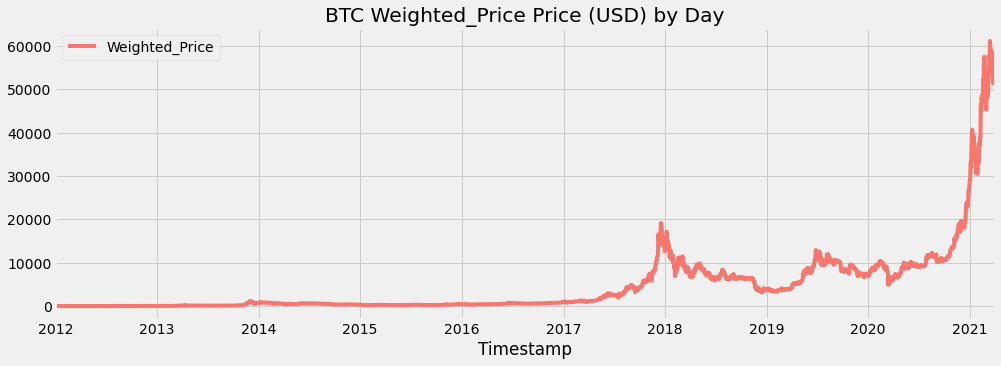

In [95]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

_ = df2.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Day')

### train - test split 70, 30

In [96]:
size = int(len(df2) * 0.7)
data_train, data_test = df2[0:size], df2[size:len(df2)]

In [97]:
data_test.rename(columns={'Weighted_Price': 'Test Set'}).join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer')

,Test Set,Training Set
Timestamp,,
2011-12-31,NaN,4.39
2012-01-01,NaN,4.58
2012-01-02,NaN,5.00
2012-01-03,NaN,5.32
2012-01-04,NaN,4.93
...,...,...
2021-03-27,55175.914921,NaN
2021-03-28,55859.414172,NaN
2021-03-29,55812.518695,NaN


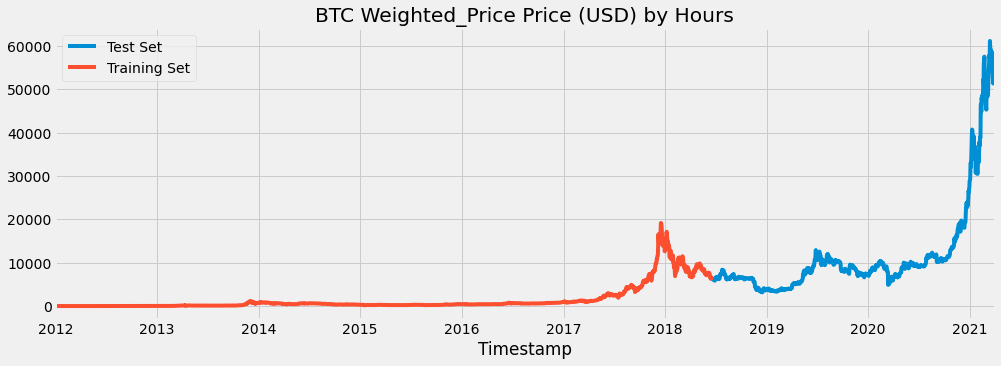

In [98]:
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

In [100]:
# a method to create a variety of features from a time series df
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label] # target
        return X, y
    return X

In [101]:
# assigning training and testing, features and labels (price)
X_train, y_train = create_features(data_train, label='Weighted_Price')
X_test, y_test = create_features(data_test, label='Weighted_Price')

### Here we use a basic XGBRegressor model,

In [103]:
# import XGBoost, then create model, and fit it to the training data
import xgboost as xgb
from xgboost import plot_importance, plot_tree

model = xgb.XGBRegressor(objective = 'reg:linear', min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                        max_depth = 5, alpha = 10, n_estimators = 100)

model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[18:29:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', ...)

In [104]:
# 預測值 y predict
# assign predictions to data_test and then data_all
data_test['Weighted_Price_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

<AxesSubplot:xlabel='Timestamp'>

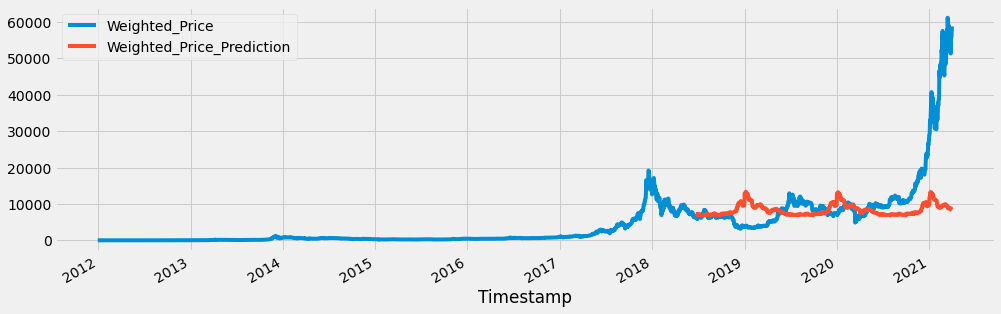

In [105]:
data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

In [106]:
rmse = np.sqrt(mean_squared_error(data_test['Weighted_Price'], data_test['Weighted_Price_Prediction']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11599.465


# Conclusion
Here we only use ARIMA and XGboost approaches, however this Bitcoin dataset consisted of extremely volatile and abnormal time series data. Therefore, we could put LSTM inside and compare their RMSE to find better model for this dataset.
In addition, the relatively optimal parameters should be also chosen among these models to get better prediction.

reference:  
https://www.kaggle.com/code/aaronfloreani/forecasting-btc-arima-xgboost-prophet-lstm